In [1]:
from scipy.spatial.transform import Rotation

import mujoco
import mujoco_viewer

import lxml.etree as ET

import numpy as np

import time

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# High level control functions.

def findSector(point):
    
    sector = 20
    
    if -23 <= point[0] and point[0] <= -12 and 2.2 < point[1] and point[1] < 13:
        sector=1
    
    if -12 <= point[0] and point[0] <= -2 and 2.2 < point[1] and point[1] < 13:
        sector=2
    
    if 2 <= point[0] and point[0] <= 12 and 2.2 < point[1] and point[1] < 13:
        sector=3
    
    if 12 <= point[0] and point[0] <= 23 and 2.2 < point[1] and point[1] < 13:
        sector=4
    
    if -23 <= point[0] and point[0] <= -3 and -3 < point[1] and point[1] < 2.2:
        sector=5
    
    if 3 <= point[0] and point[0] <= 23 and -3 < point[1] and point[1] < 2.2:
        sector=6
    
    if -3 <= point[0] and point[0] <= 3 and -3 < point[1] and point[1] < 5:
        sector=7
    
    if -3 <= point[0] and point[0] <= 3 and 5 < point[1] and point[1] < 13:
        sector=8
    
    return sector

def c2r(sector1, sector2):
    
    route=''
    
    if sector1 == 5 and sector2 == 1:
        route='dcba'
        
    if sector1 == 6 and sector2 == 1:
        route='hgfedcba'
        
    if sector1 == 7 and sector2 == 1:
        route='fedcba'

    if sector1 == 8 and sector2 == 1:
        route='ofedcba'

    if sector1 == 5 and sector2 == 2:
        route='deflmn'

    if sector1 == 6 and sector2 == 2:
        route='hgflmn'

    if sector1 == 7 and sector2 == 2:
        route='flmn'

    if sector1 == 8 and sector2 == 2:
        route='oflmn'

    if sector1 == 5 and sector2 == 3:
        route='defopqrs'

    if sector1 == 6 and sector2 == 3:
        route='hgfopqrs'

    if sector1 == 7 and sector2 == 3:
        route='fopqrs'
    
    if sector1 == 8 and sector2 == 3:
        route='pqrs'

    if sector1 == 5 and sector2 == 4:
        route='defghijk'

    if sector1 == 6 and sector2 == 4:
        route='hijk'

    if sector1 == 7 and sector2 == 4:
        route='fghijk'

    if sector1 == 8 and sector2 == 4:
        route='ofghijk'
    
    return route

def r2c(sector1):
    
    route=''
    
    if sector1 == 1: 
        route='bc'

    if sector1 == 2: 
        route='ml'

    if sector1 == 3: 
        route='rq'

    if sector1 == 4: 
        route='ji'
        
    return route
        
def generateMotionAsLetters(forkliftSector,paletSector,dropSector,forklift_position):
    
    route=''
    
    route = route + c2r(forkliftSector,paletSector) # koridor --> oda
    
    route = route + 'x' # Palet alma noktasına git
    
    route = route + r2c(paletSector) # oda --> koridor
    
    if route[-1] == 'c':
        forkliftSector=5
    if route[-1] == 'l':
        forkliftSector=7
    if route[-1] == 'q':
        forkliftSector=8
    if route[-1] == 'i':
        forkliftSector=6
        
    
    route = route + c2r(forkliftSector,dropSector) # koridor --> oda
    
    route = route + 'y' # Palet bırakma noktasına git.
    
    return route

def letters2points(route, palet_position, drop_position):
    
    goal_points=[]
    protocol=[]
    
    for char in route:
        if char == "a":
            goal_points.append([-15,9])
        if char == "b":
            goal_points.append([-13.5,5])
        if char == "c":
            goal_points.append([-13.5,-0.5])
        if char == "d":
            goal_points.append([-10,0])
        if char == "e":
            goal_points.append([-6,0])
        if char == "f":
            goal_points.append([0,0.5])
        if char == "g":
            goal_points.append([6,0])
        if char == "h":
            goal_points.append([10,0])
        if char == "i":
            goal_points.append([13.5,-0.5])
        if char == "j":
            goal_points.append([13.5,5])
        if char == "k":
            goal_points.append([15,9])
        if char == "l":
            goal_points.append([0.5,3.5])
        if char == "m":
            goal_points.append([-4,4])
        if char == "n":
            goal_points.append([-6,10])
        if char == "o":
            goal_points.append([0,5.5])
        if char == "p":
            goal_points.append([-0.5,9])
        if char == "q":
            goal_points.append([0,10.40])
        if char == "r":
            goal_points.append([5,11])
        if char == "s":
            goal_points.append([9,9])
            
        if char == "x":
            goal_points.append([palet_position[0],palet_position[1]])
            protocol.append('p')
        if char == "y":
            goal_points.append([drop_position[0],drop_position[1]])
            protocol.append('d')
        
        if char != 'x' and char != 'y':
            protocol.append('n')
        
            
    return goal_points, protocol
            

In [3]:
# Geometric functions.

def deltaBtwPoints(point1,point2):
    deltaY=point2[1]-point1[1]
    deltaX=point2[0]-point1[0]
    delta=np.sqrt(deltaX**2+deltaY**2)
    return delta

def calculateDirectionAngle(netForce):
    angle=np.rad2deg(np.arctan2(netForce[1],netForce[0]))
    return angle 

def regulateAngle(angle):
    
    angle=angle % 360
    
    if angle >= 180:
        angle=angle-360
        
    return angle

def getQuadrant(forklift_position,palet_position):
    
    if forklift_position[0] < palet_position[0] and forklift_position[1] < palet_position[1]:
        return 3
    
    elif forklift_position[0] > palet_position[0] and forklift_position[1] < palet_position[1]:
        return 2
    
    elif forklift_position[0] < palet_position[0] and forklift_position[1] > palet_position[1]:
        return 4
    
    elif forklift_position[0] > palet_position[0] and forklift_position[1] > palet_position[1]:
        return 1


In [4]:
# Physics functions.

def calculateNetForce(forkliftPoint,goalPoint,forkliftCharge,goalCharge,obsCoords,obsCharge):
    
    K=1
    netForce=[0,0]
    
    scalarForceBtwForkNGoal=(K*-forkliftCharge*goalCharge)/(deltaBtwPoints(forkliftPoint,goalPoint))**2
    distanceBtwForkNGoal=np.array(goalPoint)-np.array(forkliftPoint)
    distanceBtwForkNGoalUnitVector=distanceBtwForkNGoal/np.linalg.norm(distanceBtwForkNGoal)
    
    netForce = netForce + scalarForceBtwForkNGoal*distanceBtwForkNGoalUnitVector
    
    for obCoord in obsCoords:
        scalarForceBtwForkNOb=(K*-forkliftCharge*obsCharge)/(deltaBtwPoints(forkliftPoint,obCoord))**2        
        distanceBtwForkNOb=np.array(obCoord)-np.array(forkliftPoint)
        distanceBtwForkNObUnitVector=distanceBtwForkNOb/np.linalg.norm(distanceBtwForkNOb)
        
        netForce = netForce + scalarForceBtwForkNOb*distanceBtwForkNObUnitVector
        
    return netForce

def getObs():
    
    Obs=[]
    
    tree = ET.parse("models/atlas_transpalet/"+"small_walls"+".xml")
    root = tree.getroot()
    wall_geoms = root.findall('.//body[@class="atlas_transpalet_wall"]')

    for geom in wall_geoms:
        pos_str = geom.get('pos')
        wall_pos = pos_str.split(" ")
        size_str = geom.get('size')
        wall_size = size_str.split(" ")
        
        #print(wall_pos,wall_size)
        
        xPos=float(wall_pos[0])
        yPos=float(wall_pos[1])
        xSize=float(wall_size[0])
        ySize=float(wall_size[1])
        
        if xSize >= 1:
            for xcounter in np.arange( (xPos-xSize) , (xPos+xSize), 1 ):
                Obs.append([xcounter,yPos])
                #print([xcounter,yPos])
        
        if ySize >= 1:
            for ycounter in np.arange( (yPos-ySize) , (yPos+ySize), 1 ):
                Obs.append([xPos,ycounter])
                #print([xPos,ycounter])               
           
    return Obs

def getPaletAngle():
    tree = ET.parse("models/atlas_transpalet/palet.xml")
    root = tree.getroot()
    paletBody=root.findall('.//body[@name="palet_body"]')
    
    for paletBod in paletBody:
    
        paletAngle=paletBod.get('euler')
        
        angle=paletAngle.split(" ")
        
        yaw=np.rad2deg(float(angle[2]))
        
        yaw=regulateAngle(yaw)
        
        return yaw
    
def goalReachDistance(protocol,goalCounter):
    
    if protocol[goalCounter] == 'p':
        return 2
    
    else: 
        return 0.5
    
def returnResults(protocol,goalCounter):
    
    if protocol[goalCounter] == 'd':
        return 3
    
    if protocol[goalCounter] == 'p':
        return 2
    
    else:
        return 1


/tmp/ipykernel_7198/3318058002.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


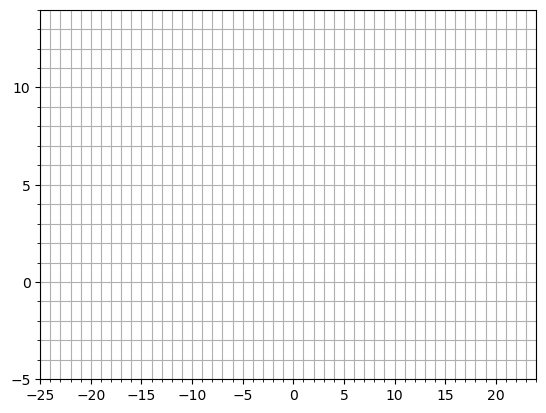

In [5]:
Obs = getObs()


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for Ob in Obs:
    ax.plot(Ob[0],Ob[1],"o")

#plt.ylim([-25,+25])
#plt.xlim([-25,+25])

xmajor_ticks = np.arange(-25, 25, 5)
xminor_ticks = np.arange(-25, 25, 1)

ymajor_ticks = np.arange(-5, 15, 5)
yminor_ticks = np.arange(-5, 15, 1)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')
fig.show()

In [6]:
# Forklift low level Controls.

def forkliftTurn(drive_speed_actuator,steering_angle_actuator,direction):
    if direction == "cw":
        drive_speed_actuator.ctrl=0.8
        steering_angle_actuator.ctrl=-1
    elif direction == "ccw":
        drive_speed_actuator.ctrl=0.8
        steering_angle_actuator.ctrl=1
        
def paletActuate(forklift_position,goal_position,
                 angleOfNetForceWrtXaxis,forklift_rotation_angles,
                 drive_speed_actuator,steering_angle_actuator,
                 goalCounter,protocol):

    myAngle=angleOfNetForceWrtXaxis-forklift_rotation_angles[0]
    myAngle=regulateAngle(myAngle)
    #print("The angle between: ",myAngle)
    
    if deltaBtwPoints([forklift_position[0],forklift_position[1]] , [goal_position[0],goal_position[1]]) < goalReachDistance(protocol,goalCounter):
        drive_speed_actuator.ctrl=-1
        steering_angle_actuator.ctrl=0
        return returnResults(protocol, goalCounter)

    elif (myAngle) < 0.7 and (myAngle) > -0.7:

        drive_speed_actuator.ctrl=-1
        steering_angle_actuator.ctrl=0

    elif (myAngle) > 5 or (myAngle) < -5:
        #drive_speed_actuator.ctrl=0.8
        #steering_angle_actuator.ctrl=-1

        if (myAngle) > 0: 
            forkliftTurn(drive_speed_actuator,steering_angle_actuator,"ccw")

        elif (myAngle) < 0:
            forkliftTurn(drive_speed_actuator,steering_angle_actuator,"cw")   
            
            
def paletFunc1(forklift_position,goal_position,
              angleOfNetForceWrtXaxis,forklift_rotation_angles,
              drive_speed_actuator,steering_angle_actuator):
    
    myAngle=angleOfNetForceWrtXaxis-forklift_rotation_angles[0]
    myAngle=regulateAngle(myAngle)
    
    if deltaBtwPoints([forklift_position[0],forklift_position[1]] , [goal_position[0],goal_position[1]]) < 0.1:
        drive_speed_actuator.ctrl=0
        steering_angle_actuator.ctrl=0
        return 1


    elif (myAngle) < 0.7 and (myAngle) > -0.7:

        drive_speed_actuator.ctrl=-1
        steering_angle_actuator.ctrl=0

    elif (myAngle) > 5 or (myAngle) < -5:

        if (myAngle) > 0: 
            forkliftTurn(drive_speed_actuator,steering_angle_actuator,"ccw")

        elif (myAngle) < 0:
            forkliftTurn(drive_speed_actuator,steering_angle_actuator,"cw")
            
def paletFunc2(forklift_rotation_angles,paletAngle,
               drive_speed_actuator,steering_angle_actuator,
               prev_quadrant,quadrant):
    
    myAngle=paletAngle-forklift_rotation_angles[0]
    myAngle=regulateAngle(myAngle)+180
    
    #print("Palet Func 2: ")
    print(paletAngle)
    print(forklift_rotation_angles[0])
    print("Turning Angle: ", myAngle)


    if (myAngle) < 0.7 and (myAngle) > -0.7:

        drive_speed_actuator.ctrl=0
        steering_angle_actuator.ctrl=0
        return 1

    elif (myAngle) > 0.7 or (myAngle) < -0.7:

        if (myAngle) > 0: 
            forkliftTurn(drive_speed_actuator,steering_angle_actuator,"cw")

        elif (myAngle) < 0:
            forkliftTurn(drive_speed_actuator,steering_angle_actuator,"ccw")
    


def paletFunc3(forklift_position, palet_position,
               drive_speed_actuator,steering_angle_actuator,fork_height_actuator,
               quadrant):
    
    drive_speed_actuator.ctrl=-1
    if deltaBtwPoints(forklift_position,palet_position) <= 0.10:
        drive_speed_actuator.ctrl=0
        steering_angle_actuator.ctrl=0
        fork_height_actuator.ctrl=1
        return 1
        

    

In [7]:
model = mujoco.MjModel.from_xml_path('models/atlas_transpalet/scene.xml')
data = mujoco.MjData(model)


drive_speed_actuator = data.actuator("drive_speed")
steering_angle_actuator = data.actuator("steering_angle")
fork_height_actuator = data.actuator("fork_height")

robot_base_link = data.site("base_link")
palet_link = data.site("palet_link")
palet_drop = data.site("palet_drop")

forklift_position = robot_base_link.xpos
palet_position = palet_link.xpos
drop_position= palet_drop.xpos

# One step to load stuff.
mujoco.mj_step(model, data)

#High level  path palnning.
forkliftSector=(findSector([forklift_position[0],forklift_position[1]]))
paletSector=(findSector([palet_position[0],palet_position[1]]))
dropSector=(findSector([drop_position[0],drop_position[1]]))
routeAsLetters = generateMotionAsLetters(forkliftSector,paletSector,dropSector,forklift_position)
goal_positions , protocol = letters2points(routeAsLetters,palet_position, drop_position)

#Low level variables.
forkliftCharge=25
goalCharge=-10
netForce=np.array([0,0])
goalCounter=0

#Parking stuff.
paletAngle=getPaletAngle()

d=1.8

possPoint1=[palet_position[0] + d*np.cos(np.deg2rad(paletAngle)) ,  palet_position[1] + d*np.sin(np.deg2rad(paletAngle))]
possPoint2=[palet_position[0] - d*np.cos(np.deg2rad(paletAngle)) ,  palet_position[1] - d*np.sin(np.deg2rad(paletAngle))]

"""
dynamic_object_actuators = [data.actuator("dynamic_object_1"), data.actuator("dynamic_object_2"), data.actuator("dynamic_object_3")]
dynamic_object_positions = [data.site("dynamic_object_1_link"), data.site("dynamic_object_2_link"), data.site("dynamic_object_3_link")]
dynamic_object_speed = 0.2

def update_dynamic_objects(step_counter):
    for dynamic_object_index in range(0, len(dynamic_object_actuators)):
        dynamic_object_actuators[dynamic_object_index].ctrl = abs(math.sin(dynamic_object_speed * math.pi * step_counter / 1000)) * 100
"""

phase="normal"
print("Starting. \nThe route is: ",goal_positions),"\n"

# Simulation
viewer = mujoco_viewer.MujocoViewer(model, data) 
for timer in range(30000):
    previous_time = data.time

    while((data.time - previous_time) < 1.0 / 60):
        #update_dynamic_objects(step_counter)
        mujoco.mj_step(model, data)
        
    if viewer.is_alive:
        
        forklift_rotation_matrix = np.array(robot_base_link.xmat).reshape(3,3)
        forklift_rotation =  Rotation.from_matrix(forklift_rotation_matrix)
        forklift_rotation_angles = forklift_rotation.as_euler("zyx",degrees=True)

        forklift_rotation_angles[0]=forklift_rotation_angles[0]-180
        if forklift_rotation_angles[0] < -180 : 
            forklift_rotation_angles[0]=forklift_rotation_angles[0]+360
        
        
        if phase == "normal":
        
            if goalCounter != len(goal_positions):
                goal_position=goal_positions[goalCounter]
        
            netForce=calculateNetForce( [forklift_position[0],forklift_position[1]] ,
                                        [goal_position[0],goal_position[1]],
                                        forkliftCharge,
                                        goalCharge,
                                        Obs, 0.01,
                                        )
            angleOfNetForceWrtXaxis=calculateDirectionAngle(netForce)
            
            result=paletActuate(forklift_position,goal_position,
                                angleOfNetForceWrtXaxis,forklift_rotation_angles,
                                drive_speed_actuator,steering_angle_actuator,
                                goalCounter,protocol)

            if result == 1 and goalCounter != len(goal_positions)-1:
                print("\nDone pursuing: ",goal_position)
                goalCounter=goalCounter+1
                print("Now pursuing: ", goal_positions[goalCounter])
                print("Net Force: ", netForce)
                print("The angle of the fork wrt +x axis: ", forklift_rotation_angles[0])

            if result == 2:
                print("Done pursuing: ",goal_position)
                goalCounter=goalCounter+1
                
                print("\nNow picking up the palet.")
                
                print("The angle of the fork wrt +x axis: ", forklift_rotation_angles[0])
                print("The angle of the palet wrt +x axis: ", paletAngle)
                
                phase='park'
                drive_speed_actuator.ctrl=0
                steering_angle_actuator.ctrl=0
                
                if deltaBtwPoints(possPoint1,[forklift_position[0],forklift_position[1]]) < deltaBtwPoints(possPoint2,[forklift_position[0],forklift_position[1]]):
                    referencePoint=possPoint1
                else:
                    referencePoint=possPoint2
                    
                goal_position=referencePoint
                print("The reference point to park is: ", referencePoint)
                
                prev_quadrant=getQuadrant(forklift_position,palet_position)
                quadrant = getQuadrant(referencePoint,palet_position)
                print("Approaching to the palet from: ", prev_quadrant, " to: ", quadrant)
                
                parkState=1
                
            if result==3:
                phase='drop'
                print("\nArrived at drop point.")
                print("Dropping the palet.")
                
        if phase == "park":
            
            netForce=calculateNetForce( [forklift_position[0],forklift_position[1]] ,
                                        [goal_position[0],goal_position[1]],
                                        forkliftCharge,
                                        goalCharge,
                                        Obs, 0,
                                        )
            angleOfNetForceWrtXaxis=calculateDirectionAngle(netForce)
            myAngle=angleOfNetForceWrtXaxis-forklift_rotation_angles[0]
            myAngle=regulateAngle(myAngle)  
            
            if parkState == 1:
            
                parkResult=paletFunc1(forklift_position,goal_position,
                                      angleOfNetForceWrtXaxis,forklift_rotation_angles,
                                      drive_speed_actuator,steering_angle_actuator)
                
                if parkResult == 1:
                    print("ParkFunc1 is complete.")
                    parkState = 2
                
            if parkState == 2:
                parkResult=paletFunc2(forklift_rotation_angles,paletAngle,
                                      drive_speed_actuator,steering_angle_actuator,
                                      prev_quadrant,quadrant)
                
                if parkResult == 1:
                    print("ParkFunc2 is complete.")
                    parkState=3
                    
            if parkState == 3:
                parkResult=paletFunc3(forklift_position, palet_position,
                                      drive_speed_actuator,steering_angle_actuator,fork_height_actuator,
                                      quadrant)
                
                if parkResult == 1:
                    print("ParkFunc3 is complete.")
                    parkState=4 
            
            if parkState == 4:
                print("Exitting park state.\n")
                phase='normal'
            
            pass
        
        
        
        
        
        
        if phase=='drop':
            fork_height_actuator.ctrl=0
            
            if deltaBtwPoints(drop_position,forklift_position) < 1:
                drive_speed_actuator.ctrl=1
                
            else:
                phase='done'
        
        if phase=='done':
            drive_speed_actuator.ctrl=0
            steering_angle_actuator.ctrl=0  
            print("\nMission Succsesful.")
            phase = 'none'
        
        viewer.render()

    else:
        break

viewer.close()

Starting. 
The route is:  [[0, 5.5], [0, 0.5], [-6, 0], [-10, 0], [-13.5, -0.5], [-13.5, 5], [-15, 9], [-18.0, 10.0], [-13.5, 5], [-13.5, -0.5], [-10, 0], [-6, 0], [0, 0.5], [6, 0], [10, 0], [13.5, -0.5], [13.5, 5], [15, 9], [20.0, 11.0]]

Done pursuing:  [0, 5.5]
Now pursuing:  [0, 0.5]
Net Force:  [-1.58962741e-01 -1.02515695e+03]
The angle of the fork wrt +x axis:  -89.94868395634772

Done pursuing:  [0, 0.5]
Now pursuing:  [-6, 0]
Net Force:  [  -19.58411277 -1033.88512999]
The angle of the fork wrt +x axis:  -89.8362837112281

Done pursuing:  [-6, 0]
Now pursuing:  [-10, 0]
Net Force:  [-1020.11637062    -9.50451853]
The angle of the fork wrt +x axis:  -173.94807873788614

Done pursuing:  [-10, 0]
Now pursuing:  [-13.5, -0.5]
Net Force:  [-1025.06434919   120.77536   ]
The angle of the fork wrt +x axis:  177.9615405374818

Done pursuing:  [-13.5, -0.5]
Now pursuing:  [-13.5, 5]
Net Force:  [-1038.02749332  -131.62023992]
The angle of the fork wrt +x axis:  -173.41441497232182

Don

-50.000039028877836
178.6296819853115
Turning Angle:  311.37027898581067
-50.000039028877836
178.17758944204633
Turning Angle:  311.82237152907584
-50.000039028877836
177.72532516316332
Turning Angle:  312.2746358079588
-50.000039028877836
177.27311797915326
Turning Angle:  312.7268429919689
-50.000039028877836
176.82108826419162
Turning Angle:  313.1788727069305
-50.000039028877836
176.36921434248873
Turning Angle:  313.63074662863346
-50.000039028877836
175.91750954318408
Turning Angle:  314.08245142793805
-50.000039028877836
175.46588889389108
Turning Angle:  314.5340720772311
-50.000039028877836
175.01421891464446
Turning Angle:  314.9857420564777
-50.000039028877836
174.56245651923194
Turning Angle:  315.4375044518902
-50.000039028877836
174.1107571328982
Turning Angle:  315.889203838224
-50.000039028877836
173.65905081024658
Turning Angle:  316.3409101608756
-50.000039028877836
173.20743288524585
Turning Angle:  316.7925280858763
-50.000039028877836
172.75580645569565
Turning Ang


Done pursuing:  [-10, 0]
Now pursuing:  [-6, 0]
Net Force:  [1046.38074937   57.2697103 ]
The angle of the fork wrt +x axis:  1.0777029570690502

Done pursuing:  [-6, 0]
Now pursuing:  [0, 0.5]
Net Force:  [1040.99505918  -94.50948791]
The angle of the fork wrt +x axis:  -3.481167130519566

Done pursuing:  [0, 0.5]
Now pursuing:  [6, 0]
Net Force:  [1019.73671904  130.70291599]
The angle of the fork wrt +x axis:  3.963273970861792

Done pursuing:  [6, 0]
Now pursuing:  [10, 0]
Net Force:  [ 991.62473798 -209.41710067]
The angle of the fork wrt +x axis:  -5.8504250182649

Done pursuing:  [10, 0]
Now pursuing:  [13.5, -0.5]
Net Force:  [1041.03075178   66.88378951]
The angle of the fork wrt +x axis:  1.9562253605330397

Done pursuing:  [13.5, -0.5]
Now pursuing:  [13.5, 5]
Net Force:  [ 985.70708702 -233.02188786]
The angle of the fork wrt +x axis:  -8.934241975647495

Done pursuing:  [13.5, 5]
Now pursuing:  [15, 9]
Net Force:  [ -12.24865176 1002.6050411 ]
The angle of the fork wrt +x

In [8]:

print(parkResult)
print(parkState)

1
4
